In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 8,
    'text.color': '#222222',
    'font.sans-serif' : 'Times New Roman',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.sorted_spikes_simulation import make_simulated_run_data
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    continuous_transition_types=continuous_transition_types,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/replay_trajectory_classification/state_transition.py:11: RuntimeWarning: invalid value encountered in true_divide
  x /= x.sum(axis=1, keepdims=True)
INFO:replay_trajectory_classification.classifier:Fitting place fields...
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/worker.py:3262: UserWarning: Large object of size 2.88 MB detected in task graph: 
  (array([0., 0., 0., ..., 0., 0., 0.]), 'ndarray-9f ... faaa6f05', 0.5)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (forma

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                    ['uniform', 'uniform']],
                       discrete_transition_diag=0.999,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=0.2775841643294233,
                       place_bin_size=0.526862566832588, position_range=None,
                       replay_speed=120, spike_model_penalty=0.5)

In [5]:
from src.sorted_spikes_simulation import make_fragmented_replay, make_continuous_replay
from src.parameters import SAMPLING_FREQUENCY

def make_continuous_fragmented_replay(
        sampling_frequency=SAMPLING_FREQUENCY):
    _, test_spikes2 = make_continuous_replay()
    _, test_spikes3 = make_fragmented_replay()

    test_spikes = np.concatenate(
        (test_spikes2, test_spikes3, test_spikes3[::-1],
         test_spikes3, test_spikes3[::-1]))
    replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

    return replay_time, test_spikes

replay_time, test_spikes = make_continuous_fragmented_replay()

replay_time *= 1000
results = classifier.predict(test_spikes, time=replay_time)

In [6]:
from src.load_data import load_data

epoch_key = ('bon', 4, 4)

data = load_data(epoch_key)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/core.py:136: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.
  periods=n_samples, unit='s', name='time')
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/well_traversal_classification.py:151: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  return (pd.DataFrame.from_items(data).set_index(index),
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-

In [38]:
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)
from loren_frank_data_processing import reshape_to_segments

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_labels = data['position_info'].arm_name

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform'],
     ['uniform',                'uniform']])

real_classifier = SortedSpikesClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=spike_model_penalty, knot_spacing=knot_spacing,
    continuous_transition_types=continuous_transition_types).fit(
        position, data['spikes'], is_training=is_training,
        track_labels=track_labels)

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
ripple_spikes = reshape_to_segments(data['spikes'], ripple_times)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


In [39]:
ripple_number = 38
ripple_time = (ripple_spikes.loc[ripple_number].index -
               ripple_spikes.loc[ripple_number].index[0])
real_results = real_classifier.predict(
    ripple_spikes.loc[ripple_number],
    time=ripple_time).assign_coords(
        time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's'),
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

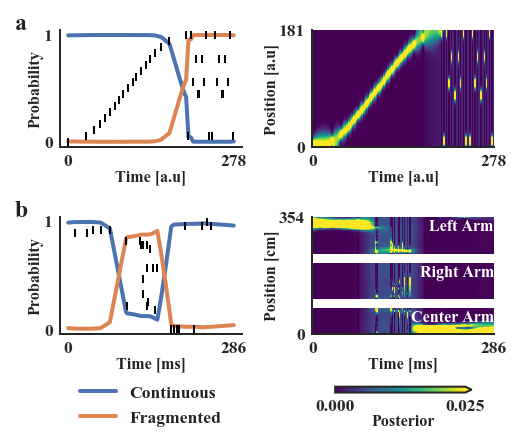

In [40]:
from src.analysis import get_place_field_max
from src.figure_utilities import ONE_COLUMN, GOLDEN_RATIO

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(ONE_COLUMN, 3))

cbar_kwargs = {
    'ticks': [0, 0.025],
    'orientation': 'horizontal',
    'shrink': 0.75,
}

spike_kwargs = {
    'zorder': 0,
    'color': 'black',
    'marker': '|',
    's': 20, 
    'linewidth': 1,
}

results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[0, 0], add_legend=False, linewidth=2)
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_xlabel('Time [a.u]')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticks([results.time.min(), results.time.max()])

spike_time_ind, neuron_ind = np.nonzero(test_spikes)
twinx = plt.twinx(axes[0, 0])
twinx.scatter(results.time[spike_time_ind], neuron_ind, **spike_kwargs)
twinx.set_yticks([])

results.acausal_posterior.sum('state').plot(
    x='time', y='position', ax=axes[0, 1], vmin=0, vmax=0.025,
    rasterized=True, add_colorbar=False)
axes[0, 1].set_ylabel('Position [a.u]')
axes[0, 1].set_xlabel('Time [a.u]')
axes[0, 1].set_yticks([0, np.ceil(results.position.max())])
axes[0, 1].set_xticks([results.time.min(), results.time.max()])

h = real_results.acausal_posterior.sum('position').plot(
    x='time', hue='state', ax=axes[1, 0], add_legend=False, linewidth=2)
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_xlabel('Time [ms]')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticks([real_results.time.min(), real_results.time.max()])
axes[1, 0].legend(['Continuous', 'Fragmented'], loc='upper center', bbox_to_anchor=(0.5, -0.3),
                  ncol=1, frameon=False)

place_field_max = get_place_field_max(real_classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
spike_time_ind, neuron_ind = np.nonzero(ripple_spikes.loc[ripple_number].values[:, linear_position_order])
twinx = plt.twinx(axes[1, 0])
twinx.scatter(real_results.time[spike_time_ind], neuron_ind, **spike_kwargs)
twinx.set_yticks([])

min_df = (data['position_info']
      .groupby('arm_name')['linear_position'].min())
max_df = (data['position_info']
          .groupby('arm_name')['linear_position'].max())
is_between_arms = ((real_results.position > max_df['Center Arm']) & (real_results.position < min_df['Right Arm']) |
                   (real_results.position > max_df['Right Arm']) & (real_results.position < min_df['Left Arm']))

real_results.acausal_posterior.rename('Posterior').sum('state').where(~is_between_arms).plot(
    x='time', y='position', ax=axes[1, 1], vmin=0, vmax=0.025,
    rasterized=True, cbar_kwargs=cbar_kwargs)
axes[1, 1].set_ylabel('Position [cm]')
axes[1, 1].set_xlabel('Time [ms]')
axes[1, 1].set_xticks([real_results.time.min(), real_results.time.max()])
axes[1, 1].set_yticks([0, np.ceil(real_results.position.max())])

max_time = np.asarray(real_results.time.max())
for arm_name, max_position in max_df.iteritems():
    axes[1, 1].text(max_time, max_position - 5, arm_name, color='white',
                 fontsize=8, verticalalignment='top', horizontalalignment='right')


sns.despine()
axes[0, 0].text(-0.25, 1.0, 'a', transform=axes[0, 0].transAxes, 
        size=12, weight='extra bold')
axes[1, 0].text(-0.25, 1.0, 'b', transform=axes[1, 0].transAxes, 
        size=12, weight='extra bold')

plt.savefig('/Users/edeno/Documents/GitHub/Characterizing-hippocampal-replay-using-hybrid-point-process-state-space-models/fig1.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

In [20]:
len(place_field_max)

32

In [23]:
from loren_frank_data_processing import make_neuron_dataframe

make_neuron_dataframe(ANIMALS).xs(epoch_key)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/neurons.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for cellfile, animal in neuron_data


area  deadchans  fs hemisphere  meanrate  \
tetrode_number neuron_number                                            
1              1              CA3        NaN NaN      right  0.314835   
               2              CA3        NaN NaN      right  0.022412   
               3              CA3        NaN NaN      right  0.001067   
               4              CA3        NaN NaN      right  0.005336   
               5              CA3        NaN NaN      right  0.009605   
...                           ...        ...  ..        ...       ...   
27             1              CA3        NaN NaN      right  0.073639   
29             1              CA1        NaN NaN      right  0.000000   
               2              CA1        NaN NaN      right  0.001067   
               3              CA1        NaN NaN      right  0.002134   
               4              CA1        NaN NaN      right  2.440768   

                              nearCA2          neuron_id  numspikes  peakrate  \
tetrode_number neuron_number                                                    
1              1                  0.0  bon_04_04_001_001      295.0       NaN   
               2                  0.0  bon_04_04_001_002       21.0       NaN   
               3                  0.0  bon_04_04_001_003        1.0       NaN   
               4                  0.0  bon_04_04_001_004        5.0       NaN   
               5                  0.0  bon_04_04_001_005        9.0       NaN   
...                               ...                ...        ...       ...   
27             1                  0.0  bon_04_04_027_001       69.0       NaN   
29             1                  0.0  bon_04_04_029_001        0.0       NaN   
               2                  0.0  bon_04_04_029_002        1.0       NaN   
               3                  0.0  bon_04_04_029_003        2.0       NaN   
               4                  0.0  bon_04_04_029_004     2287.0       NaN   

                              spikewidth subarea suparea  tetnum       type  
tetrode_number neuron_number                                                 
1              1                7.864462    CA3b     NaN     NaN  principal  
               2                7.604728    CA3b     NaN     NaN    unknown  
               3                7.351811    CA3b     NaN     NaN    unknown  
               4                7.080079    CA3b     NaN     NaN    unknown  
               5                7.679394    CA3b     NaN     NaN    unknown  
...                                  ...     ...     ...     ...        ...  
27             1                7.732275    CA3b     NaN     NaN    unknown  
29             1                     NaN    CA1c     NaN     NaN  principal  
               2                9.173757    CA1c     NaN     NaN    unknown  
               3                8.856989    CA1c     NaN     NaN    unknown  
               4                9.204049    CA1c     NaN     NaN  principal  

[74 rows x 14 columns]

In [24]:
max_df

arm_name
Center Arm     75.655082
Left Arm      352.282872
Right Arm     212.959995
Name: linear_position, dtype: float64

In [33]:
y=100
(y-1)/y

0.99

In [27]:
discrete_diag

0.999

In [34]:
movement_var

4.0